In [1]:
import numpy as np
import matplotlib.path
import math
import matplotlib.pyplot as plt
import pyregion
import numpy.ma as ma
from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy import wcs
from astropy import units as u
from astroquery.simbad import Simbad
from glob import glob
import os

https://www.treywenger.com/kd/index.php

In [2]:
###----------- Constants ---------###
pc2cm = 3.0857e+18                  # parsec in cm
yr2s  = 3.154e+7                    # year in sec
Msun = 1.98892e+33                  # gm
muH2 = 2.37                         # For solar abundance (H=0.7, He=0.28, Z=0.02)
mH = 1.67356e-24                    # gm
#######################################
############  CO specific #############
#######################################
H2toCO = 1.0e+04                    # CO abundance ratio
CoeffA = [4.34e+13, 4.32e+13, 4.81e+12, 2.70e+12] # from Hunter PhD thesis P206; four transitions of CO, i.e, 1-0, 2-1, 3-2, 4-3
CoeffB = [5.52, 16.56, 33.12, 88.50]

In [3]:
def PerFrameMassMomentumEnergy(Tb, Xpix, Ypix, distance, decl, deltav, excitation_temp, jlow, vel):
    dist = distance * pc2cm
    x = dist * math.radians(Xpix) * math.cos(math.radians(decl))
    y = dist * math.radians(Ypix) 

    COcol = CoeffA[jlow] * (excitation_temp + 0.92) * (math.exp(CoeffB[jlow]/excitation_temp)) * (Tb*deltav)  ##specific to CO
    H2col = COcol * H2toCO
    # print('>>', x, y, COcol, H2col)

    H2mass = muH2 * x * y * mH * H2col
    H2mass = H2mass / Msun
    P = H2mass * vel
    E = (0.5 * H2mass * vel * vel)*(Msun * 1000 * 1000) #converting to joules
    return H2mass, P, E

def Cal_DynAge_OutflowRate(H2mass, Llobe, Vmax):
    tdyn = Llobe / Vmax
    Mdot = H2mass / tdyn
    return

def ConvertJy2K(I, hd, fr):
        # Formula from https://science.nrao.edu/facilities/vla/proposing/TBconv
        bmaj = float(hd['BMAJ'])*3600. # in arcsec
        bmin = float(hd['BMIN'])*3600. # in arcsec
        freq = fr/1.0e+09              # in GHz
        T = (1.222e+6 * I)/(freq*freq*bmaj*bmin) # for I in Jy/beam
        return T

def Cal_COMassMomentumEnergy(SpecFile, reg_name, excitation_temp, jlow, V_start, V_end, v_lsr, outflow_length, dist):
    with fits.open(SpecFile) as Ccube:
        header = Ccube[0].header
        data = Ccube[0].data
        w = wcs.WCS(Ccube[0].header)
        #print(f"Number of WCS axes: {w.naxis}")
        zlen, ylen, xlen = data.shape

        xpix = float(abs(header['CDELT1']))
        ypix = float(abs(header['CDELT2']))
        dV = float(header['CDELT3'])
        freq = float(header['RESTFRQ'])
        
        # Convert pixel coordinates to world coordinates
        RAc, DEc, _, _ = w.wcs_pix2world(xlen/2, ylen/2, zlen/2, 0, 0) 
        
        # Convert world coordinates to pixel coordinates
        # Here, `0` is used for the additional dimension; adjust as needed
        V_start_pix = w.wcs_world2pix(RAc, DEc, V_start*1000, 0,0)[2]
        V_end_pix = w.wcs_world2pix(RAc, DEc, V_end*1000, 0,0)[2]
        
        r = pyregion.open(reg_name).as_imagecoord(header=header)
        mask = r.get_mask(shape=(ylen, xlen))

        TotalMass = []
        TotalMom = []
        TotalEner = []

        V_start_pix = int(V_start_pix)
        print('V_start_pix =', V_start_pix)
        V_end_pix = int(V_end_pix)
        print('V_end_pix =', V_end_pix)

        if V_end_pix < V_start_pix:
            V_start_pix, V_end_pix = V_end_pix, V_start_pix

        V_start = abs(V_start - v_lsr)
        print('V_start =', V_start)
        V_end = abs(V_end - v_lsr)
        print('V_end =', V_end)

        if V_end < V_start:
            V_start, V_end = V_end, V_start


        for i in range(V_start_pix, V_end_pix):
            maData = ma.masked_array(data[i], mask=~mask)
            bright_temp = ConvertJy2K(np.nansum(maData), header, freq) #bright_temp = np.sum(maData)
            Velocity = V_start + (i * abs(dV))
            mass, mom, energy = PerFrameMassMomentumEnergy(bright_temp, xpix, ypix, dist, DEc, abs(dV), excitation_temp, jlow, Velocity)
            TotalMass.append(mass)
            TotalMom.append(mom)
            TotalEner.append(energy)

        Mtot = np.sum(TotalMass)
        Ptot = np.sum(TotalMom)
        Etot = np.sum(TotalEner)
        tdyn = ((outflow_length * pc2cm) / (V_end * 1.0e+5)) / yr2s
        Mout = Mtot / tdyn

        return Mtot, Ptot, Etot, tdyn, Mout

def calculate_length(reg_file, distance):
    # Generate the length file name
    length_file = reg_file.replace('.reg', '_length.reg')
    #print('length_file=',length_file)
    # Open the length file and read the content
    with open(length_file, 'r') as file:
        lines = file.readlines()

    # Extract the line containing the coordinates
    for line in lines:
        if line.startswith('line'):
            # Extract ra1, dec1, ra2, dec2 from the line
            coords = line.split('(')[1].split(')')[0].split(',')
            ra1 = float(coords[0])
            dec1 = float(coords[1])
            ra2 = float(coords[2])
            dec2 = float(coords[3])
            
            # Calculate dRA and dDEC
            dRA = (ra2 - ra1)
            dDEC = (dec2 - dec1)
            
            # Calculate the angular distance r in degrees
            r_deg = math.sqrt(dRA ** 2 + dDEC ** 2)
            #print('r_deg=', r_deg)
            
            # Convert the angular distance to radians
            r_rad = math.radians(r_deg)
            #print('r_rad=', r_rad)
            
            # Calculate the physical distance in parsecs
            r_parsec = r_rad * distance
            
            # Return the calculated physical distance
            return r_parsec

## IRAS 14498-5856 CO

In [12]:
excitation_temp = 50  # Excitation temperature in K
jlow = 2  # Transition: 2 for CO(3-2)
v_lsr = -50

# Configure Simbad to return the necessary fields
custom_simbad = Simbad()
custom_simbad.add_votable_fields('coordinates')

# Query SIMBAD for the object and extract RA and Dec
result = custom_simbad.query_object("IRAS 14498-5856")
ra, dec = result['RA'][0], result['DEC'][0]

# Convert RA and Dec to Galactic coordinates
coord = SkyCoord(ra=ra, dec=dec, unit=(u.hourangle, u.deg), frame='icrs')
l, b = coord.galactic.l.deg, coord.galactic.b.deg
print(f"Galactic Longitude (l): {l:.6f} degrees")
print(f"Galactic Latitude (b): {b:.6f} degrees")

distance = 3.2 * 1000  # Distance in parsecs (from https://www.treywenger.com/kd/index.php)
SpecFile = '/media/sanjana/One Touch/Toolkit/OutflowProject/ALMAData/IRAS 14498-5856 _CO_/IRAS 14498-5856 _CO__spectral_axis_vel.fits'

# Define regions with their corresponding start and end velocities and region file names bbrrrrr
regions = [
    {"V_start": -54.2634, "V_end": -120.3050, "reg_name": "reg1_wcs.reg"},
    {"V_start": -55.1101, "V_end": -120.3050, "reg_name": "reg2_wcs.reg"},
    {"V_start": -48.3366, "V_end": -32.2497, "reg_name": "reg3_wcs.reg"},
    {"V_start": -48.3366, "V_end": -21.2428, "reg_name": "reg4_wcs.reg"},
    {"V_start": -47.49, "V_end": 33.7916, "reg_name": "reg5_wcs.reg"},
    {"V_start": -47.49, "V_end": -24.6295, "reg_name": "reg6_wcs.reg"},
    {"V_start": -47.49, "V_end": -22.9361, "reg_name": "reg7_wcs.reg"},
]

# Loop through the regions to calculate and print results
for region in regions:
    V_start = region["V_start"]
    V_end = region["V_end"]
    reg_name = f'/home/sanjana/academic++/schools_workshops_internships/SNBNCBS/param_calc/I4498_CO_param_calc_{region["reg_name"]}'
    
    outflow_length = calculate_length(reg_name, distance)
    print(f'Outflow length: {outflow_length:.4f} parsecs')

    M, P, E, tdyn, Mdot = Cal_COMassMomentumEnergy(
        SpecFile, reg_name, excitation_temp, jlow, V_start, V_end, v_lsr, outflow_length, distance
    )
    
    print(f'Mass: {M:6.3e} M_sun, Momentum: {P:6.3e} M_sun.km/sec, Energy: {E:6.3e} Joules, '
          f'Dynamical time: {tdyn:8.1f} years, Outflow rate: {Mdot:6.3e} M_sun/year')
    print('-----------------------------------------------------------')

Galactic Longitude (l): 318.048451 degrees
Galactic Latitude (b): 0.086058 degrees
Outflow length: 0.7984 parsecs
V_start_pix = 179
V_end_pix = 258
V_start = 4.263399999999997
V_end = 70.305
Mass: 2.563e-01 M_sun, Momentum: 4.205e+01 M_sun.km/sec, Energy: 6.872e+42 Joules, Dynamical time:  11110.4 years, Outflow rate: 2.307e-05 M_sun/year
-----------------------------------------------------------
Outflow length: 0.5349 parsecs


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


V_start_pix = 181
V_end_pix = 258
V_start = 5.110100000000003
V_end = 70.305
Mass: 9.815e-02 M_sun, Momentum: 1.612e+01 M_sun.km/sec, Energy: 2.639e+42 Joules, Dynamical time:   7443.0 years, Outflow rate: 1.319e-05 M_sun/year
-----------------------------------------------------------
Outflow length: 0.4103 parsecs


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


V_start_pix = 172
V_end_pix = 154
V_start = 1.6634000000000029
V_end = 17.750300000000003
Mass: 3.474e-02 M_sun, Momentum: 4.953e+00 M_sun.km/sec, Energy: 7.025e+41 Joules, Dynamical time:  22615.7 years, Outflow rate: 1.536e-06 M_sun/year
-----------------------------------------------------------
Outflow length: 0.2280 parsecs


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


V_start_pix = 172
V_end_pix = 141
V_start = 1.6634000000000029
V_end = 28.7572
Mass: 6.391e-02 M_sun, Momentum: 8.995e+00 M_sun.km/sec, Energy: 1.260e+42 Joules, Dynamical time:   7756.2 years, Outflow rate: 8.240e-06 M_sun/year
-----------------------------------------------------------
Outflow length: 0.6489 parsecs


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


V_start_pix = 172
V_end_pix = 76
V_start = 2.509999999999998
V_end = 83.7916
Mass: 1.820e-01 M_sun, Momentum: 2.577e+01 M_sun.km/sec, Energy: 3.638e+42 Joules, Dynamical time:   7576.6 years, Outflow rate: 2.402e-05 M_sun/year
-----------------------------------------------------------
Outflow length: 0.2161 parsecs


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


V_start_pix = 172
V_end_pix = 144
V_start = 2.509999999999998
V_end = 25.3705
Mass: 2.997e-02 M_sun, Momentum: 4.291e+00 M_sun.km/sec, Energy: 6.114e+41 Joules, Dynamical time:   8332.6 years, Outflow rate: 3.596e-06 M_sun/year
-----------------------------------------------------------
Outflow length: 0.1535 parsecs


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


V_start_pix = 172
V_end_pix = 142
V_start = 2.509999999999998
V_end = 27.0639
Mass: 1.170e-02 M_sun, Momentum: 1.670e+00 M_sun.km/sec, Energy: 2.372e+41 Joules, Dynamical time:   5549.0 years, Outflow rate: 2.108e-06 M_sun/year
-----------------------------------------------------------


## IRAS 16060-5146 CO

In [5]:
excitation_temp = 13  # Excitation temperature in K
jlow = 2  # Transition: 2 for CO(3-2)
v_lsr = -89.95

# Configure Simbad to return the necessary fields
custom_simbad = Simbad()
custom_simbad.add_votable_fields('coordinates')

# Query SIMBAD for the object and extract RA and Dec
result = custom_simbad.query_object("IRAS 16060-5146")
ra, dec = result['RA'][0], result['DEC'][0]

# Convert RA and Dec to Galactic coordinates
coord = SkyCoord(ra=ra, dec=dec, unit=(u.hourangle, u.deg), frame='icrs')
l, b = coord.galactic.l.deg, coord.galactic.b.deg
print(f"Galactic Longitude (l): {l:.6f} degrees")
print(f"Galactic Latitude (b): {b:.6f} degrees")

distance = 5.31 * 1000  # Distance in parsecs (from https://www.treywenger.com/kd/index.php)
SpecFile = '/media/sanjana/One Touch/Toolkit/OutflowProject/ALMAData/IRAS 16060-5146 _CO_/IRAS 16060-5146 _CO__spectral_axis_vel.fits'

# Define regions with their corresponding start and end velocities and region file names br
regions = [
    {"V_start": -99.263, "V_end": -139.901, "reg_name": "reg1_wcs.reg"},
    {"V_start": -62.0111, "V_end": -86.5635, "reg_name": "reg2_wcs.reg"},
]

# Loop through the regions to calculate and print results
for region in regions:
    V_start = region["V_start"]
    V_end = region["V_end"]
    reg_name = f'/home/sanjana/academic++/schools_workshops_internships/SNBNCBS/param_calc/I16060_CO_param_calc_{region["reg_name"]}'
    
    outflow_length = calculate_length(reg_name, distance)
    print(f'Outflow length: {outflow_length:.4f} parsecs')

    M, P, E, tdyn, Mdot = Cal_COMassMomentumEnergy(
        SpecFile, reg_name, excitation_temp, jlow, V_start, V_end, v_lsr, outflow_length, distance
    )
    
    print(f'Mass: {M:6.3e} M_sun, Momentum: {P:6.3e} M_sun.km/sec, Energy: {E:6.3e} Joules, '
          f'Dynamical time: {tdyn:8.1f} years, Outflow rate: {Mdot:6.3e} M_sun/year')
    print('-----------------------------------------------------------')

Galactic Longitude (l): 330.954529 degrees
Galactic Latitude (b): -0.181843 degrees
Outflow length: 0.8782 parsecs


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


V_start_pix = 186
V_end_pix = 233
V_start = 9.313000000000002
V_end = 49.95100000000001
Mass: 2.316e+00 M_sun, Momentum: 4.109e+02 M_sun.km/sec, Energy: 7.260e+43 Joules, Dynamical time:  17199.8 years, Outflow rate: 1.347e-04 M_sun/year
-----------------------------------------------------------
Outflow length: 0.8682 parsecs
V_start_pix = 141
V_end_pix = 171
V_start = 27.938900000000004
V_end = 3.386499999999998
Mass: 1.538e+00 M_sun, Momentum: 2.139e+02 M_sun.km/sec, Energy: 2.963e+43 Joules, Dynamical time:  30402.7 years, Outflow rate: 5.059e-05 M_sun/year
-----------------------------------------------------------


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


## IRAS 16272-4837 CO

In [6]:
excitation_temp = 13  # Excitation temperature in K
jlow = 2  # Transition: 2 for CO(3-2)
v_lsr = -46.42

# Configure Simbad to return the necessary fields
custom_simbad = Simbad()
custom_simbad.add_votable_fields('coordinates')

# Query SIMBAD for the object and extract RA and Dec
result = custom_simbad.query_object("IRAS 16272-4837")
ra, dec = result['RA'][0], result['DEC'][0]

# Convert RA and Dec to Galactic coordinates
coord = SkyCoord(ra=ra, dec=dec, unit=(u.hourangle, u.deg), frame='icrs')
l, b = coord.galactic.l.deg, coord.galactic.b.deg
print(f"Galactic Longitude (l): {l:.6f} degrees")
print(f"Galactic Latitude (b): {b:.6f} degrees")

distance = 3.32 * 1000  # Distance in parsecs (from https://www.treywenger.com/kd/index.php)
SpecFile = '/media/sanjana/One Touch/Toolkit/OutflowProject/ALMAData/IRAS 16272-4837 _CO_/IRAS 16272-4837 _CO__spectral_axis_vel.fits'

# Define regions with their corresponding start and end velocities and region file names - bbbrrrrr
regions = [
    {"V_start": -50.6532, "V_end": -70.9723, "reg_name": "reg1_wcs.reg"},
    {"V_start": -49.8065, "V_end": -98.0644, "reg_name": "reg2_wcs.reg"},
    {"V_start": -48.9599, "V_end": -89.5981, "reg_name": "reg3_wcs.reg"},
    {"V_start": -1.54859, "V_end": -45.5734, "reg_name": "reg4_wcs.reg"},
    {"V_start": 17.9239, "V_end": -46.42, "reg_name": "reg5_wcs.reg"},
    {"V_start": -1.54859, "V_end": -46.42, "reg_name": "reg6_wcs.reg"},
    {"V_start": -15.9413, "V_end": -45.5734, "reg_name": "reg7_wcs.reg"},
    {"V_start": -23.561, "V_end": -45.5734, "reg_name": "reg8_wcs.reg"},
]

# Loop through the regions to calculate and print results
for region in regions:
    V_start = region["V_start"]
    V_end = region["V_end"]
    reg_name = f'/home/sanjana/academic++/schools_workshops_internships/SNBNCBS/param_calc/I16272_CO_param_calc_{region["reg_name"]}'
    
    outflow_length = calculate_length(reg_name, distance)
    print(f'Outflow length: {outflow_length:.4f} parsecs')

    M, P, E, tdyn, Mdot = Cal_COMassMomentumEnergy(
        SpecFile, reg_name, excitation_temp, jlow, V_start, V_end, v_lsr, outflow_length, distance
    )
    
    print(f'Mass: {M:6.3e} M_sun, Momentum: {P:6.3e} M_sun.km/sec, Energy: {E:6.3e} Joules, '
          f'Dynamical time: {tdyn:8.1f} years, Outflow rate: {Mdot:6.3e} M_sun/year')
    print('-----------------------------------------------------------')

Galactic Longitude (l): 335.587002 degrees
Galactic Latitude (b): -0.289996 degrees
Outflow length: 0.3062 parsecs


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


V_start_pix = 180
V_end_pix = 204
V_start = 4.2331999999999965
V_end = 24.552300000000002
Mass: 5.292e-02 M_sun, Momentum: 8.501e+00 M_sun.km/sec, Energy: 1.359e+42 Joules, Dynamical time:  12199.7 years, Outflow rate: 4.337e-06 M_sun/year
-----------------------------------------------------------
Outflow length: 0.4646 parsecs
V_start_pix = 178
V_end_pix = 235
V_start = 3.386499999999998
V_end = 51.644400000000005


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Mass: 3.074e-01 M_sun, Momentum: 5.053e+01 M_sun.km/sec, Energy: 8.278e+42 Joules, Dynamical time:   8800.7 years, Outflow rate: 3.493e-05 M_sun/year
-----------------------------------------------------------
Outflow length: 0.2443 parsecs


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


V_start_pix = 178
V_end_pix = 225
V_start = 2.539899999999996
V_end = 43.1781
Mass: 2.987e-01 M_sun, Momentum: 4.896e+01 M_sun.km/sec, Energy: 7.997e+42 Joules, Dynamical time:   5535.7 years, Outflow rate: 5.395e-05 M_sun/year
-----------------------------------------------------------
Outflow length: 0.5878 parsecs


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


V_start_pix = 121
V_end_pix = 174
V_start = 44.871410000000004
V_end = 0.8466000000000022
Mass: 1.440e-01 M_sun, Momentum: 2.016e+01 M_sun.km/sec, Energy: 2.816e+42 Joules, Dynamical time:  12816.8 years, Outflow rate: 1.124e-05 M_sun/year
-----------------------------------------------------------
Outflow length: 0.4040 parsecs


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


V_start_pix = 99
V_end_pix = 174
V_start = 64.3439
V_end = 0.0
Mass: 2.889e-01 M_sun, Momentum: 3.891e+01 M_sun.km/sec, Energy: 5.239e+42 Joules, Dynamical time:   6142.1 years, Outflow rate: 4.703e-05 M_sun/year
-----------------------------------------------------------
Outflow length: 0.4584 parsecs


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


V_start_pix = 121
V_end_pix = 174
V_start = 44.871410000000004
V_end = 0.0
Mass: 5.545e-02 M_sun, Momentum: 7.708e+00 M_sun.km/sec, Energy: 1.069e+42 Joules, Dynamical time:   9994.8 years, Outflow rate: 5.548e-06 M_sun/year
-----------------------------------------------------------
Outflow length: 0.1666 parsecs


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


V_start_pix = 138
V_end_pix = 174
V_start = 30.478700000000003
V_end = 0.8466000000000022
Mass: 6.832e-03 M_sun, Momentum: 9.293e-01 M_sun.km/sec, Energy: 1.262e+41 Joules, Dynamical time:   5346.5 years, Outflow rate: 1.278e-06 M_sun/year
-----------------------------------------------------------
Outflow length: 0.3489 parsecs


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


V_start_pix = 148
V_end_pix = 174
V_start = 22.859
V_end = 0.8466000000000022
Mass: 1.542e-02 M_sun, Momentum: 2.164e+00 M_sun.km/sec, Energy: 3.024e+41 Joules, Dynamical time:  14932.4 years, Outflow rate: 1.033e-06 M_sun/year
-----------------------------------------------------------


## Trend Plots

<>:9: SyntaxWarning: invalid escape sequence '\o'
<>:10: SyntaxWarning: invalid escape sequence '\o'
<>:10: SyntaxWarning: invalid escape sequence '\o'
<>:9: SyntaxWarning: invalid escape sequence '\o'
<>:10: SyntaxWarning: invalid escape sequence '\o'
<>:10: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_29603/3656260915.py:9: SyntaxWarning: invalid escape sequence '\o'
  "$V_{start}$ (km/s)", "$V_{end}$ (km/s)", "Outflow Length (pc)", "Mass ($M_{\odot}$)",
/tmp/ipykernel_29603/3656260915.py:10: SyntaxWarning: invalid escape sequence '\o'
  "Momentum ($M_{\odot}$·km/s)", "Energy (J)", "Dynamical Time (yrs)", "Outflow Rate ($M_{\odot}$/yr)"
/tmp/ipykernel_29603/3656260915.py:10: SyntaxWarning: invalid escape sequence '\o'
  "Momentum ($M_{\odot}$·km/s)", "Energy (J)", "Dynamical Time (yrs)", "Outflow Rate ($M_{\odot}$/yr)"


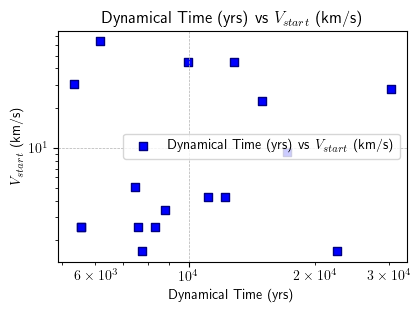

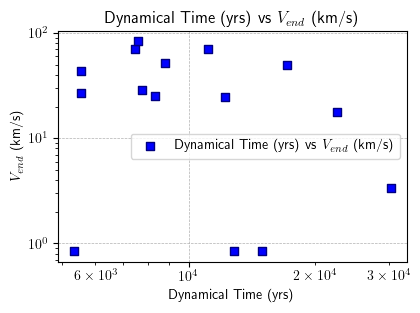

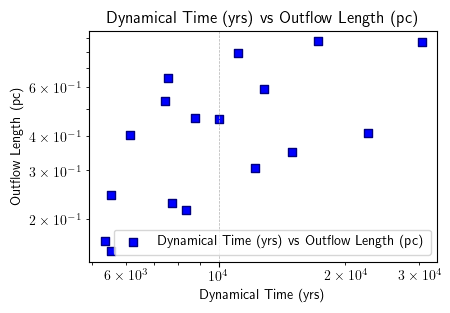

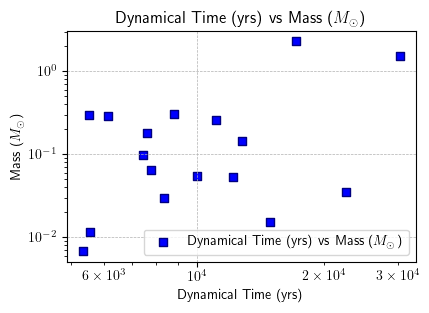

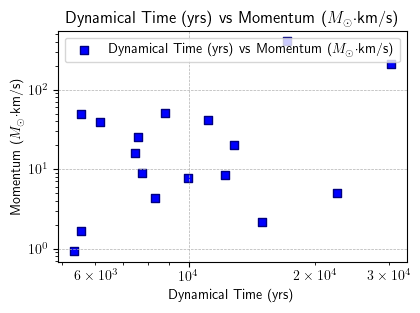

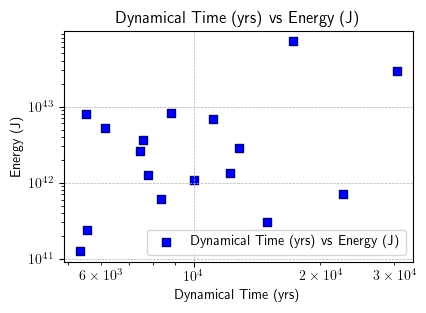

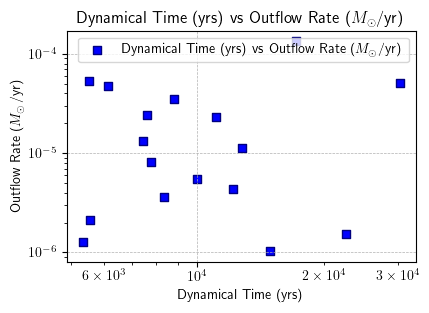

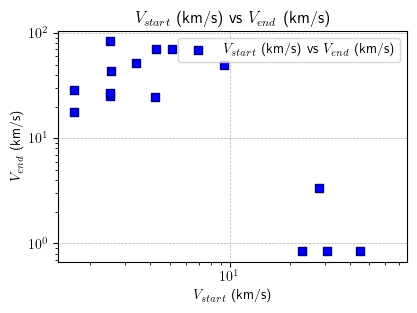

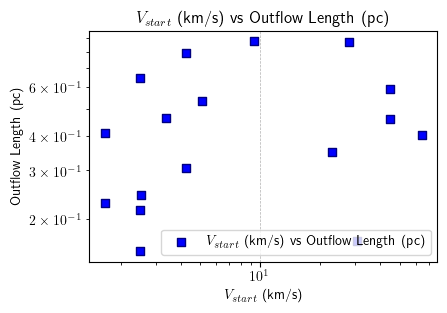

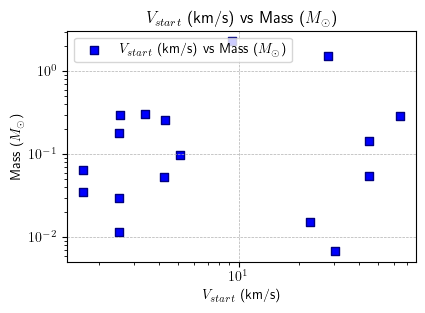

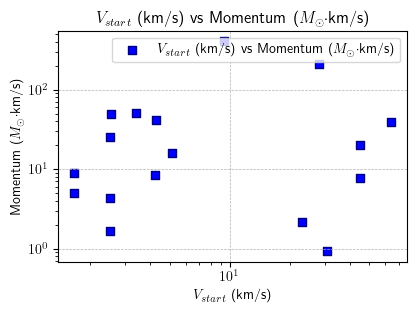

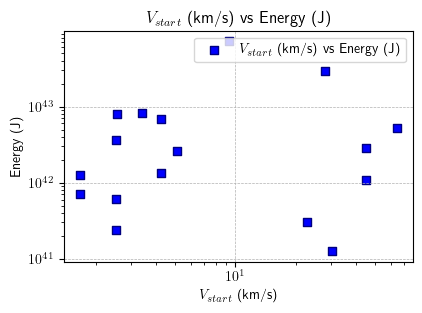

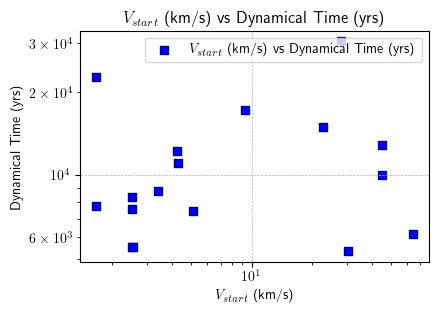

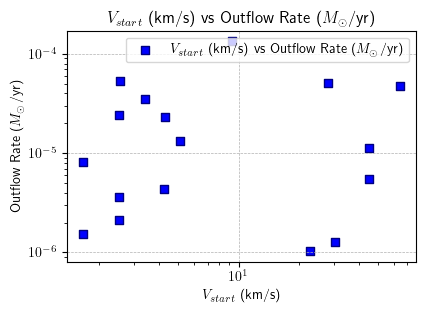

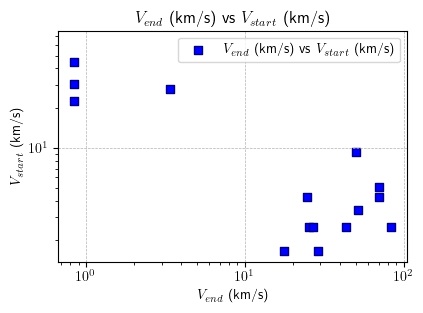

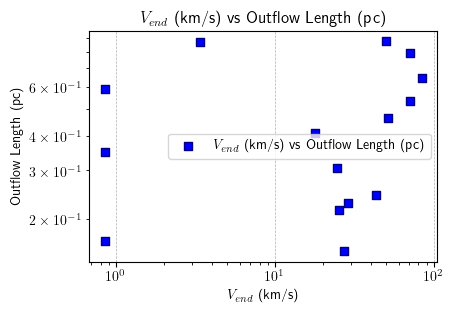

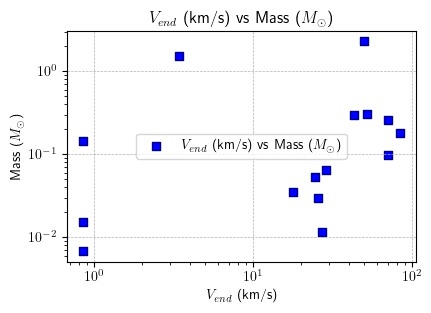

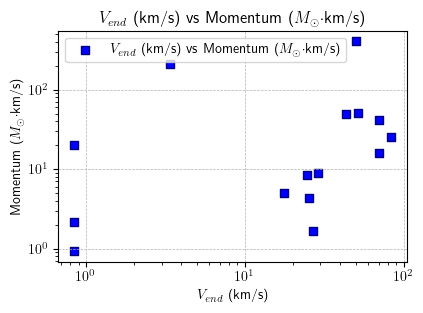

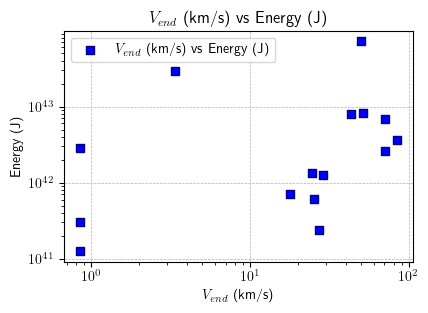

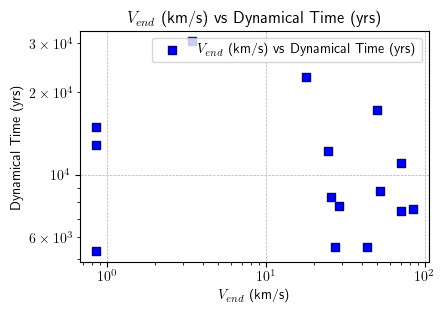

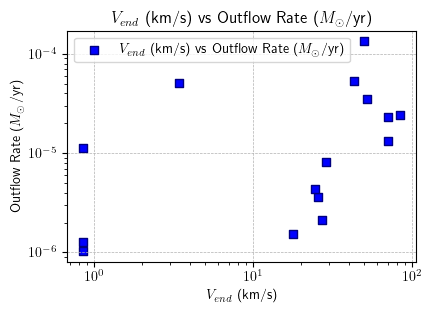

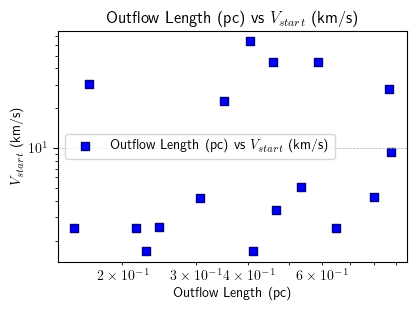

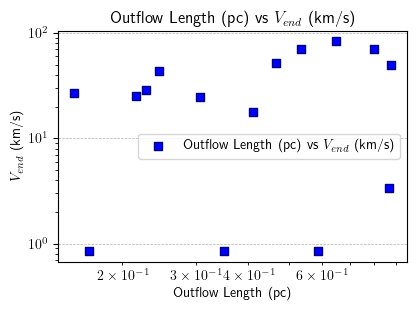

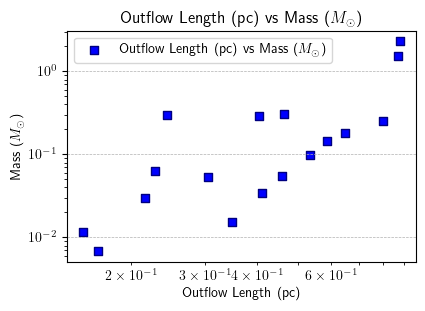

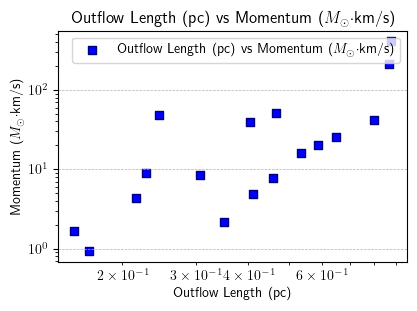

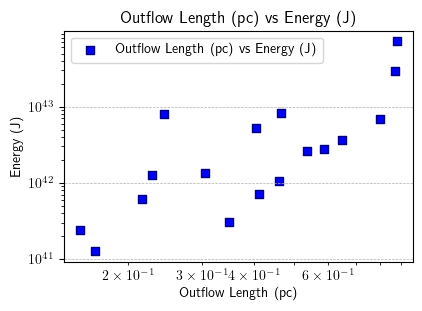

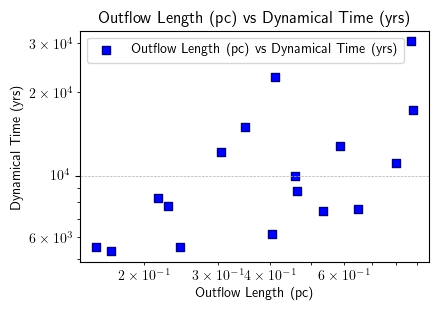

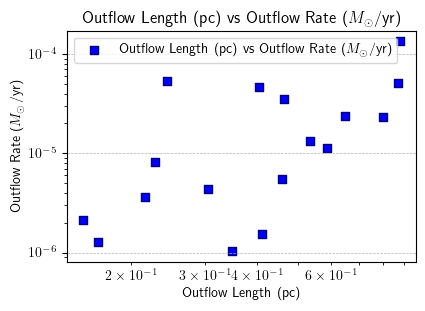

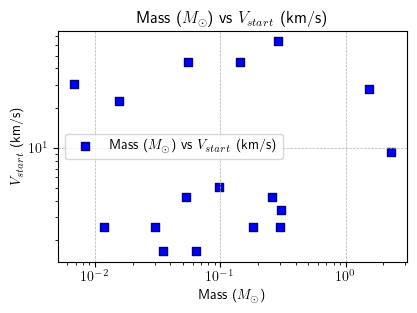

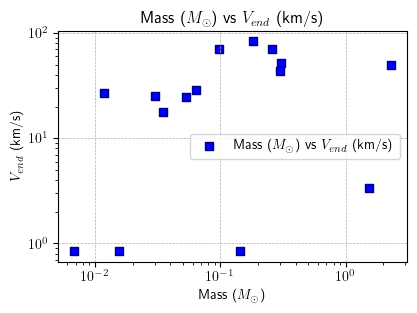

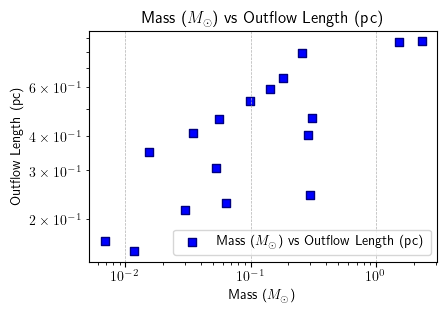

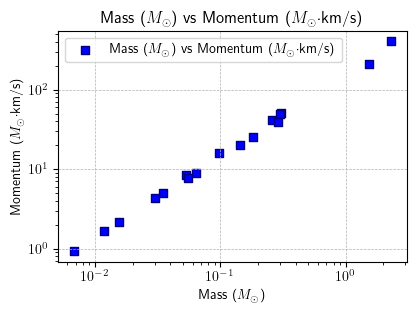

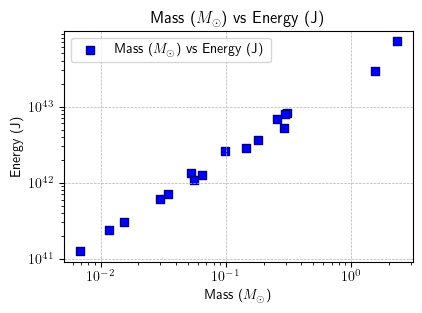

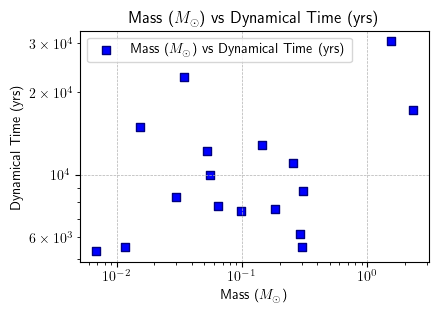

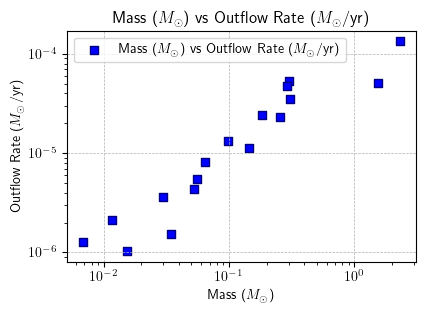

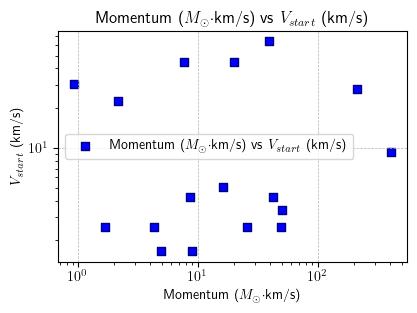

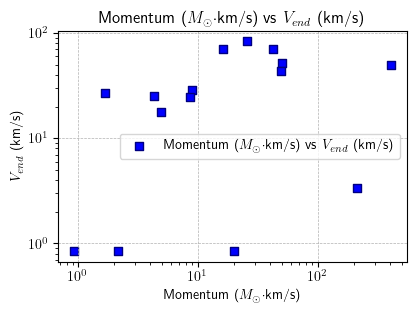

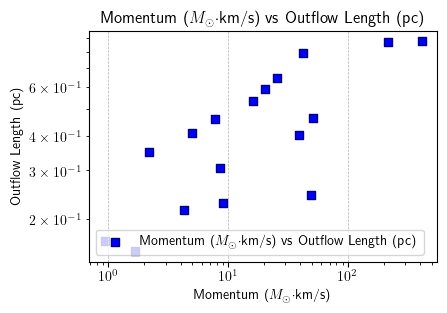

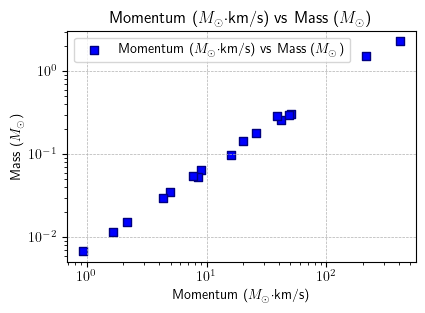

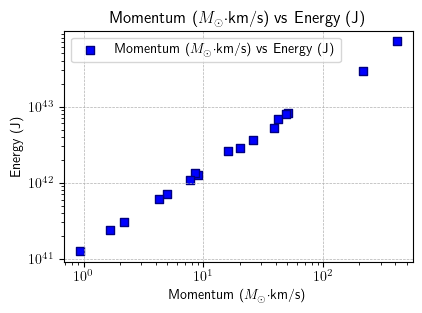

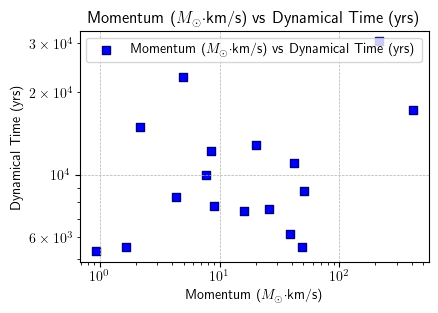

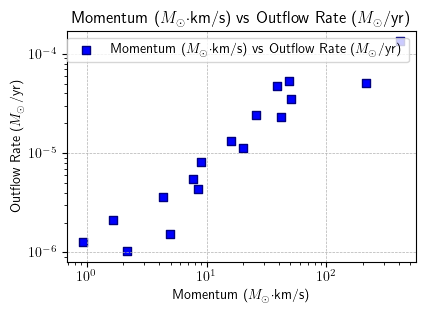

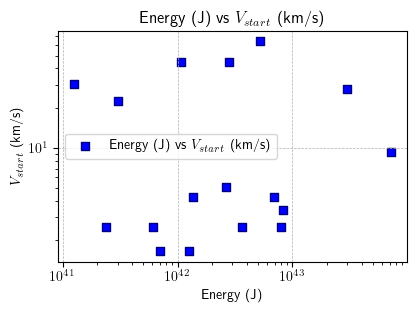

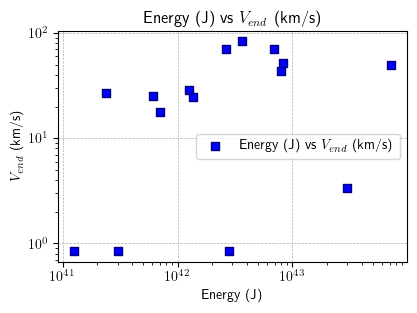

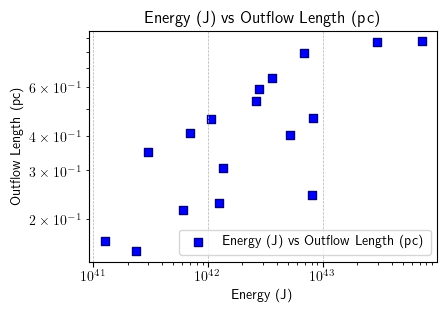

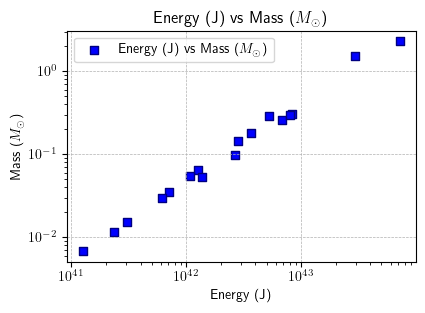

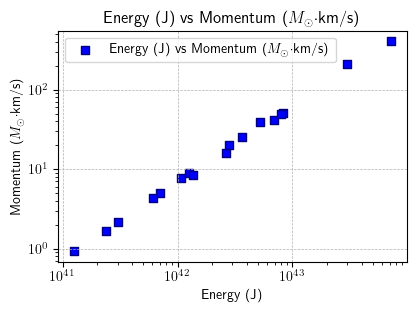

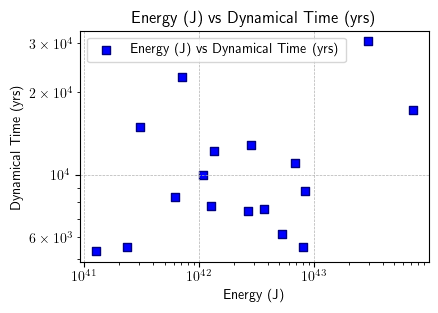

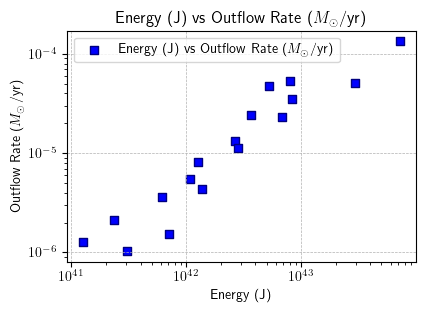

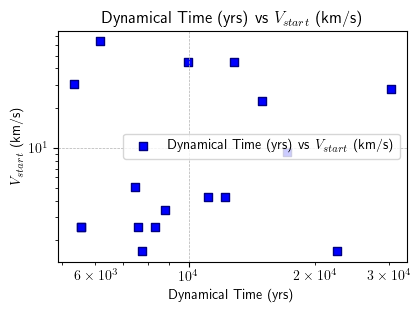

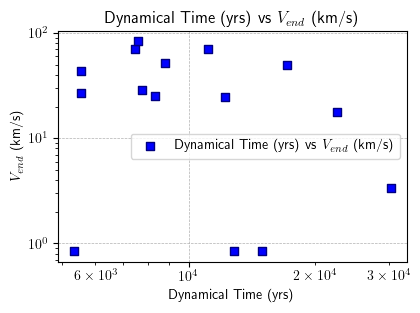

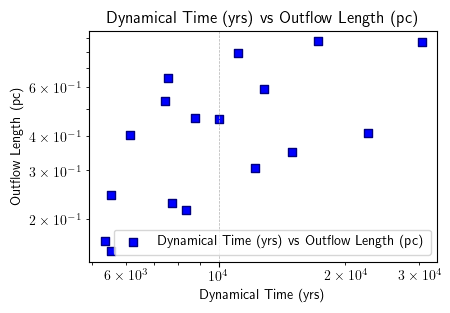

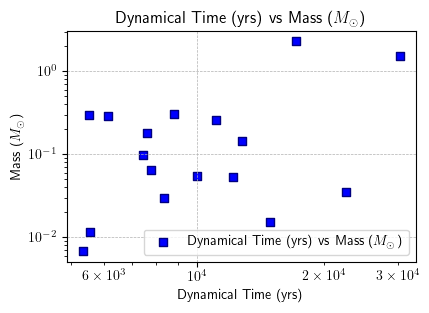

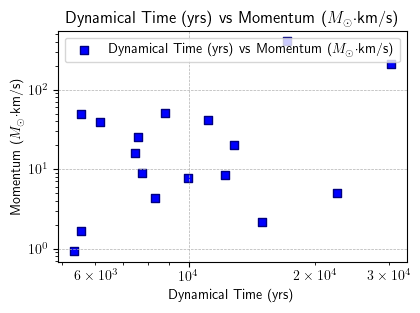

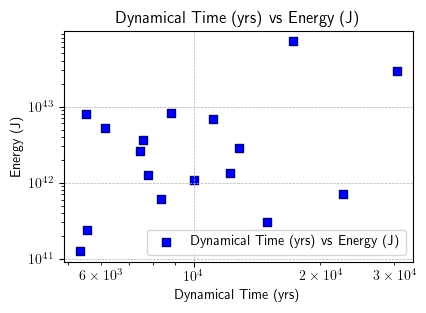

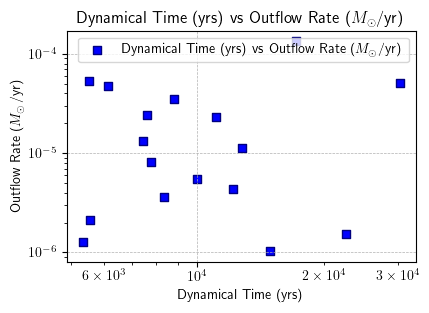

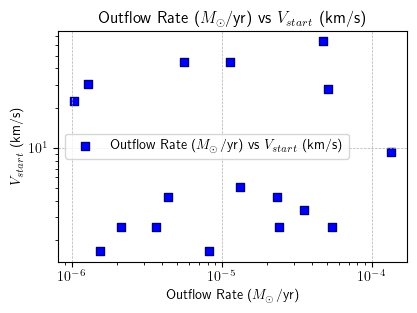

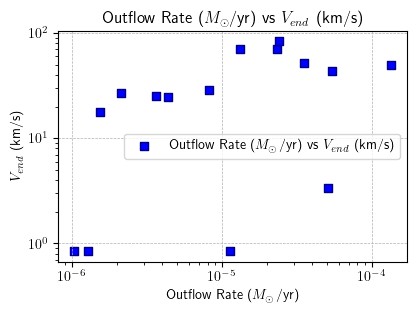

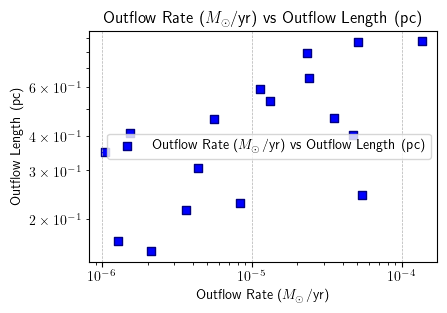

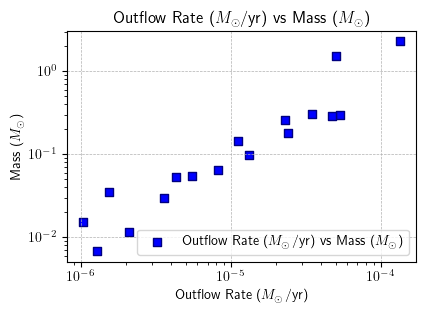

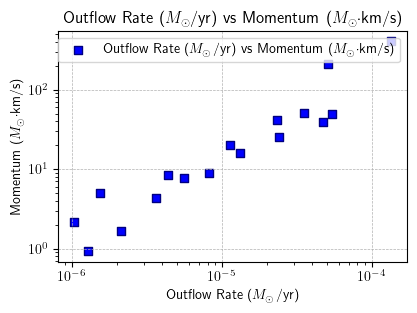

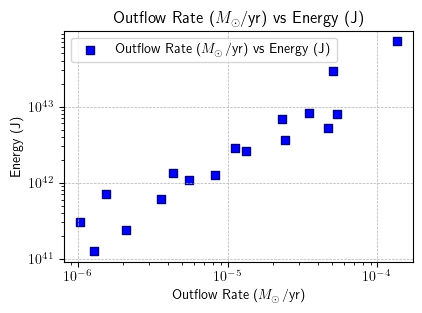

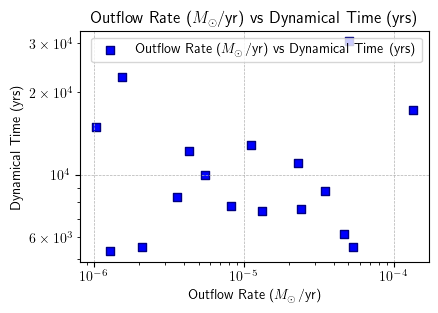

In [25]:
# Convert to numpy array
parameters = np.array([
    data["Vstart"], data["Vend"], data["Outflow Length"], data["Mass"],
    data["Momentum"], data["Energy"], data["Dynamical Time"], data["Outflow Rate"]
]).T

# Parameter names for plotting
param_names = [
    "$V_{start}$ (km/s)", "$V_{end}$ (km/s)", "Outflow Length (pc)", "Mass ($M_{\odot}$)",
    "Momentum ($M_{\odot}$·km/s)", "Energy (J)", "Dynamical Time (yrs)", "Outflow Rate ($M_{\odot}$/yr)"
]

# Index of "Dynamical Time"
x_index = param_names.index("Dynamical Time (yrs)")

# Create the directory if it doesn't exist
output_dir = 'outflow_parameters'
os.makedirs(output_dir, exist_ok=True)

# Plot "Dynamical Time" against all other parameters
for j in range(len(param_names)):
    if j == x_index:
        continue  # Skip plotting "Dynamical Time" against itself
    
    plt.figure(figsize=(4.5, 3))
    x = parameters[:, x_index]
    y = parameters[:, j]
    
    # Scatter plot with navy square markers and blue border
    plt.scatter(x, y, marker='s', label=f'{param_names[x_index]} vs {param_names[j]}',
                color='blue', edgecolor='navy')

    # Set log scale for both axes
    plt.xscale('log')
    plt.yscale('log')
    
    plt.xlabel(param_names[x_index])
    plt.ylabel(param_names[j])
    plt.title(f'{param_names[x_index]} vs {param_names[j]}')
    plt.legend()
    plt.grid(True, ls="--", linewidth=0.5)
    
    # Save the figure with '_log' in the filename
    filename = f"{param_names[x_index].replace('$', '').replace('/', '').replace('·', '').replace(' ', '_')}_vs_{param_names[j].replace('$', '').replace('/', '').replace('·', '').replace(' ', '_')}_log.png"
    plt.savefig(os.path.join(output_dir, filename), dpi=300, bbox_inches='tight')
    plt.show()

# Plot all parameters against all other parameters
for i in range(len(param_names)):
    for j in range(len(param_names)):
        if i == j:
            continue  # Skip plotting a parameter against itself
        
        plt.figure(figsize=(4.5, 3))
        x = parameters[:, i]
        y = parameters[:, j]
        
        # Scatter plot with navy square markers and blue border
        plt.scatter(x, y, marker='s', label=f'{param_names[i]} vs {param_names[j]}',
                    color='blue', edgecolor='navy')

        # Set log scale for both axes
        plt.xscale('log')
        plt.yscale('log')
        
        plt.xlabel(param_names[i])
        plt.ylabel(param_names[j])
        plt.title(f'{param_names[i]} vs {param_names[j]}')
        plt.legend()
        plt.grid(True, ls="--", linewidth=0.5)
        
        # Save the figure with '_log' in the filename
        filename = f"{param_names[i].replace('$', '').replace('/', '').replace('·', '').replace(' ', '_')}_vs_{param_names[j].replace('$', '').replace('/', '').replace('·', '').replace(' ', '_')}_log.png"
        plt.savefig(os.path.join(output_dir, filename), dpi=300, bbox_inches='tight')
        plt.show()


3. pluto simulations
4. convert all figures to aplpy
5. Also do mass calculation for HCO+ data - make sure while saving it is saved in wcs fk5 degrees

## treywenger

In [7]:
from kd import rotcurve_kd
glong = 318.048451 # Galactic longitude, degrees
glat = 00.086058 # Galactic latitude, degrees
velo = -50 # measured LSR velocity, km/s
velo_tol = 0.1 # tolerance to determine a "match" between rotation curve and measured LSR velocity (km/s)
rotcurve = 'reid14_rotcurve' # the name of the script containing the rotation curve
dist = rotcurve_kd.rotcurve_kd(glong, glat, velo, velo_tol=velo_tol, rotcurve=rotcurve)
print(dist['near'])

ModuleNotFoundError: No module named 'kd'